<a href="https://colab.research.google.com/github/ahlqui/VeloxChemColabs/blob/main/UV_Vis_spectrum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# Calculate UV/Vis spectrum using TDDFT


This notebook requires that you have a molecular structure. Two options:

Define Molecule as XYZ-coordinates: Can be generatred with free software such as www.avogadro.cc

Define Molecule with SMILES code, A molecule can be defined using a SMILES code (example below). We have two suggested ways to generate smiles from structure. 1) Sketch your molecule at https://www.rcsb.org/chemical-sketch and the SMILES code will be shown right below the structure. 2) Build your molecule at https://molview.org/ , go to Tools/Information Card and it will show you the SMILES code. Just copy/paste it into the SMILES box below.

Example of xyz-coordinates for CO2:

O 0.00 0.00 0.00

C 0.00 0.00 1.20

O 0.00 0.00 2.40

Example of SMILES for CO2:

O=C=O

In [1]:
#@title Install VeloxChem and dependencies (ca 1 min)
#@markdown Before you can run anything a few things need to be installed. It all runs on the Google Colab server an you do not need to install anything on your computer.
%%capture
import sys

!wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh
!bash Mambaforge-Linux-x86_64.sh -bfp /usr/local
!mamba config --set auto_update_conda false
!mamba install --yes -c conda-forge -c veloxchem veloxchem openbabel py3Dmol matplotlib python=3.10

sys.path.append('/usr/local/lib/python3.10/site-packages/')

import veloxchem as vlx

In [ ]:
xyz_coordinates = """
N     0.4785967928750  -0.4330741880750  -0.4934317502006
H     1.3794564278886   0.0429751463168  -0.5120458348956
C     0.4573285404340  -1.3154740355836  -1.6452845209868
H     1.2794157350200  -2.0270971721773  -1.5868316520123
H    -0.4697908768414  -1.8882598290096  -1.6558792536570
C     0.3747047426388  -1.2102491878280   0.7331072010194
H    -0.4082292852521  -1.9567463178277   0.6148319854093
H     1.2952953868059  -1.7540437197433   0.9183116804327
C     0.6956425554192   0.9059967227241  -5.3588904651214
C     1.6690431285267  -0.0704102447688  -5.0614336089256
C     1.5905279342425  -0.7922292640998  -3.8527793116028
C     0.5421211238334  -0.5430166236398  -2.9451176135833
C    -0.4312572408155   0.4285446612223  -3.2497814984180
C    -0.3564249048118   1.1570067527526  -4.4544417171718
H     0.7549521548685   1.4652126122086  -6.2812972715425
H     2.3338053657174  -1.5390048087124  -3.6163728176857
H    -1.2215586002930   0.6165771400284  -2.5371827271696
C    -0.5809783149118   1.1061887532548   4.2819306994214
C    -1.0539691464599  -0.2152180430193   4.1484967454886
C    -0.7402866542775  -0.9585904738513   2.9917812697427
C     0.0501603450518  -0.3918335577218   1.9715484114033
C     0.5329231859523   0.9234697295847   2.1220017776407
C     0.2096151223583   1.6793509886579   3.2655299818144
H    -0.8298576406810   1.6816374807225   5.1614537759970
H    -1.1155297675244  -1.9639771384900   2.8737258346041
H     1.1311551788061   1.3586475153088   1.3389498331805
C     2.7985412681099  -0.3440921389086  -6.0320361103160
H     3.0137177612643  -1.4119025048439  -6.0784904425001
H     2.5433990952730  -0.0090827377477  -7.0376742707821
H     3.7013243404231   0.1769923076871  -5.7132670703364
C    -1.3956677617432   2.2110713683443  -4.7713360805252
H    -2.2850215726603   2.0829577471538  -4.1532353918110
H    -0.9892606342753   3.2051959925139  -4.5854917335667
H    -1.6989550492144   2.1496453780473  -5.8166145479409
C    -1.9096053739985  -0.8269385079269   5.2372774019485
H    -1.8730938416183  -1.9157634078951   5.1986764605346
H    -1.5629099527925  -0.5125717843390   6.2218512212214
H    -2.9465170241487  -0.5126306418706   5.1188520156529
C     0.7055071531436   3.1039291474455   3.3878074482962
H     0.6996321098764   3.5926125742168   2.4126899821207
H     0.0720511304863   3.6841458846608   4.0587668370105
H     1.7245462284362   3.1151446899290   3.7742478882927
"""


In [2]:
#@title Define your molecule, either asa SMILES code or xyz-coordinates above
#@markdown - Enter the SMILES code
smiles_code = 'OCCC=O' #@param {type:"string"}
#@markdown - If you want to use the xyz coordinates in the previous cell check box
use_xyz = False # @param {type:"boolean"}
if use_xyz == False:
  molecule = vlx.Molecule.read_smiles(smiles_code)
else:
  molecule = vlx.Molecule.read_str(xyz_coordinates)
print('Structure of the molecule entered: ')
molecule.show(atom_indices=True)
#@markdown - Give your Gromacs files a name
gromacs_file = 'test' #@param {type:"string"}
#@markdown - Give your molecule a residue name (three letters)
residue_name = 'tes' #@param {type:"string"}



Structure of the molecule entered: 


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [3]:
#@title XTB optimization of the geometry
#@markdown Example timing: Ibuprofen (59 sec)
scf_drv = vlx.XtbDriver()
scf_drv.ostream.mute()

opt_drv = vlx.OptimizationDriver(scf_drv)
opt_drv.ostream.mute()
opt_results = opt_drv.compute(molecule)

final_geometry = vlx.Molecule.read_xyz_string(opt_results["final_geometry"])
final_geometry.show()
print('Energy of optimized structure: ' + str(opt_results["opt_energies"][-1]))
print('XYZ coordinates of optimized structure:')
print(opt_results["final_geometry"])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Energy of optimized structure: -17.57375769652727
XYZ coordinates of optimized structure:
11

O              1.060992723510         0.035722900663         0.077357501145
C              2.469533730599         0.084962314164         0.050847170053
C              2.991579293763        -1.176073318824         0.729814735472
C              4.487431754131        -1.262865267233         0.776546511525
O              5.108120053930        -2.164682419197         1.262109449183
H              0.703480695133         0.822467598572        -0.346237255555
H              2.835020975900         0.974690749945         0.584869517916
H              2.835022087902         0.128952449702        -0.985907739410
H              2.602561268150        -2.056612876425         0.211932863183
H              2.602559561241        -1.228480119698         1.750012602108
H              5.007927855741        -0.400182011668         0.312054644379



DFT energy: -268.1496620025 a.u.
Energy [au]  Osc. str.   TM(x)     TM(y)     TM(z)
   0.155      0.00002  -0.00000  -0.00672  -0.01249
   0.223      0.00674   0.15299  -0.13061   0.07032
   0.270      0.00124   0.00002  -0.03936  -0.07309
   0.275      0.01881  -0.28372   0.13104  -0.07056
   0.276      0.00023  -0.00002  -0.01668  -0.03099
   0.298      0.05816  -0.49061  -0.20185   0.10868


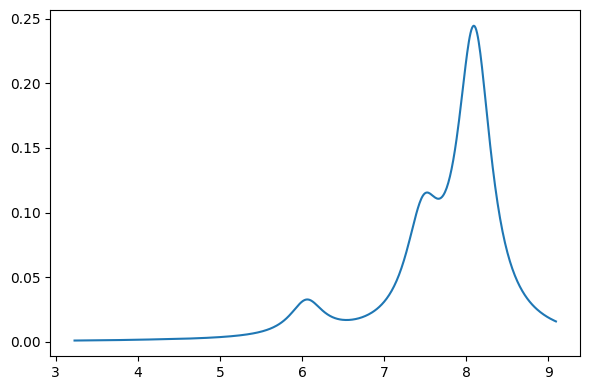

In [4]:
#@title TDDFT to generate UV/Vis spectrum
import matplotlib.pyplot as plt
import numpy as np
import py3Dmol as p3d
import veloxchem as vlx
from matplotlib import gridspec
from scipy.interpolate import interp1d

# au to eV conversion factor
au2ev = 27.211386

molecule = vlx.Molecule.read_xyz_string(opt_results["final_geometry"])
basis_set = 'DEF2-SVP' #@param  ['6-31++G', '6-31++G*', '6-31++G**', '6-31+G', '6-31+G*', '6-31+G**', '6-311++G', '6-311++G(2D,2P)', '6-311++G(3DF,3PD)', '6-311++G*', '6-311++G**', '6-311+G', '6-311+G(2D,P)', '6-311+G*', '6-311+G**', '6-311G', '6-311G(2DF,2PD)', '6-311G*', '6-311G**', '6-31G', '6-31G(2DF,P)', '6-31G(3DF,3PD)', '6-31G*', '6-31G**', 'ANO-L-MB', 'ANO-L-VDZP', 'ANO-L-VQZP', 'ANO-L-VTZP', 'ANO-S-MB', 'ANO-S-VDZP', 'AO-START-GUESS', 'AUG-CC-PCV5Z', 'AUG-CC-PCVDZ', 'AUG-CC-PCVQZ', 'AUG-CC-PCVTZ', 'AUG-CC-PV5Z', 'AUG-CC-PV6Z', 'AUG-CC-PVDZ', 'AUG-CC-PVQZ', 'AUG-CC-PVTZ', 'AUG-PCSEG-0', 'AUG-PCSEG-1', 'AUG-PCSEG-2', 'AUG-PCSEG-3', 'AUG-PCSEG-4', 'AUG-PCX-1', 'AUG-PCX-2', 'AUG-PCX-3', 'AUG-PCX-4', 'CC-PCV5Z', 'CC-PCVDZ', 'CC-PCVQZ', 'CC-PCVTZ', 'CC-PV5Z', 'CC-PV6Z', 'CC-PVDZ', 'CC-PVQZ', 'CC-PVTZ', 'DAUG-CC-PCV5Z', 'DAUG-CC-PCVDZ', 'DAUG-CC-PCVQZ', 'DAUG-CC-PCVTZ', 'DAUG-CC-PV5Z', 'DAUG-CC-PV6Z', 'DAUG-CC-PVDZ', 'DAUG-CC-PVQZ', 'DAUG-CC-PVTZ', 'DEF2-QZVP', 'DEF2-QZVPD', 'DEF2-QZVPP', 'DEF2-QZVPPD', 'DEF2-SV(P)', 'DEF2-SVP', 'DEF2-SVPD', 'DEF2-TZVP', 'DEF2-TZVPD', 'DEF2-TZVPP', 'DEF2-TZVPPD', 'PCSEG-0', 'PCSEG-1', 'PCSEG-2', 'PCSEG-3', 'PCSEG-4', 'PCX-1', 'PCX-2', 'PCX-3', 'PCX-4', 'SADLEJ-PVTZ', 'STO-3G', 'STO-3G-OLD', 'STO-6G', 'TAUG-CC-PCV5Z', 'TAUG-CC-PCVDZ', 'TAUG-CC-PCVQZ', 'TAUG-CC-PCVTZ', 'TAUG-CC-PV5Z', 'TAUG-CC-PV6Z', 'TAUG-CC-PVDZ', 'TAUG-CC-PVQZ', 'TAUG-CC-PVTZ']
basis = vlx.MolecularBasis.read(molecule, basis_set)
scf_drv = vlx.ScfRestrictedDriver()
mute_output = True # @param {type:"boolean"}
if mute_output == True:
  scf_drv.ostream.mute()
else:
  scf_drv.ostream
functional = 'B3LYP' #@param ['SLATER', 'SLDA', 'B88X', 'BLYP', 'B3LYP', 'BHANDH', 'BHANDHLYP', 'PBE', 'PBE0', 'REVPBE', 'BP86', 'PW91', 'MPW1K', 'OLYP', 'O3LYP', 'X3LYP', 'B97', 'B97-1', 'B97-2', 'B97-3', 'TPSS', 'TPSSH', 'REVTPSS', 'PKZB', 'SCAN', 'RSCAN', 'R2SCAN', 'M05', 'M05-2X', 'M06', 'M06-2X', 'M06-HF', 'M06-L', 'M11-L', 'MPW1B95', 'MPWB1K', 'PW6B95', 'PWB6K']
scf_drv.xcfun = functional
scf_results = scf_drv.compute(molecule, basis)
print(f"DFT energy: {scf_drv.get_scf_energy():14.10f} a.u.")
method_settings = {"xcfun":functional}
rpa_solver = vlx.lreigensolver.LinearResponseEigenSolver()
mute_output_tddft = True # @param {type:"boolean"}
if mute_output_tddft == True:
  rpa_solver.ostream.mute()
else:
  rpa_solver.ostream
Number_of_excitations = 6 # @param {type:"integer"}
rpa_solver.update_settings({"nstates": Number_of_excitations}, method_settings)
rpa_results = rpa_solver.compute(molecule, basis, scf_results)

def lorentzian(x, y, xmin, xmax, xstep, gamma):
    xi = np.arange(xmin, xmax, xstep)
    yi = np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(x)):
            yi[i] = yi[i] + y[k] * (gamma / 2.0) / (
                (xi[i] - x[k]) ** 2 + (gamma / 2.0) ** 2
            )
    return xi, yi


# Print results as a table
print("Energy [au]  Osc. str.   TM(x)     TM(y)     TM(z)")
for i in np.arange(len(rpa_results["eigenvalues"])):
    e, os, x, y, z = (
        rpa_results["eigenvalues"][i],
        rpa_results["oscillator_strengths"][i],
        rpa_results["electric_transition_dipoles"][i][0],
        rpa_results["electric_transition_dipoles"][i][1],
        rpa_results["electric_transition_dipoles"][i][2],
    )
    print("   {:.3f}     {:8.5f}  {:8.5f}  {:8.5f}  {:8.5f}".format(e, os, x, y, z))

plt.figure(figsize=(6, 4))
x = au2ev * rpa_results["eigenvalues"]
y = rpa_results["oscillator_strengths"]
xi, yi = lorentzian(x, y, min(x) - 1.0, max(x) + 1.0, 0.01, 0.5)
plt.plot(xi, yi)
plt.tight_layout()
plt.show()


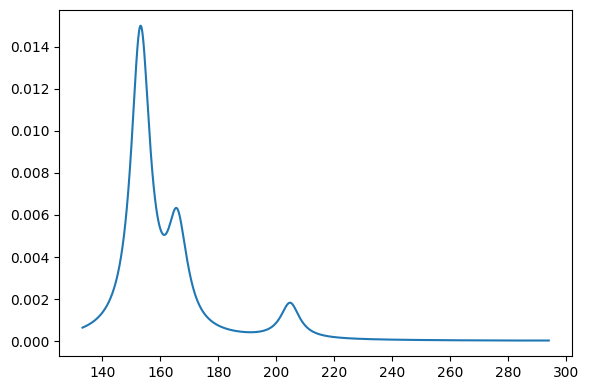

In [23]:
#@title Plot UV/Vis spectrum in nm
plt.figure(figsize=(6, 4))
x =  45.56328 / rpa_results["eigenvalues"]
y = rpa_results["oscillator_strengths"]
xi, yi = lorentzian(x, y, min(x) - 20.0, max(x) + 1.0, 0.1, 8)
plt.plot(xi, yi)
plt.tight_layout()
plt.show()